0_methods_C_particles_factor.ipynb  
# Generate artificial particle fields that are multiplied with a factor

**Notebook input:**
- runs: SPIN3INTEL (from modeldir)    

**Notebook output (written to savedir):**  
Netcdf files with scaled particle fields, suitable for Bern3D model:
- PART_X2___.0001765_full_ave.nc
- PART_X3___.0001765_full_ave.nc
- PART_X5___.0001765_full_ave.nc
- PART_DIV_2.0001765_full_ave.nc

**Notebook comments:**   
- We scale the usual Bern3D pre-industrial particle fields (e.g., as in the CTRL run) by a factor 2, 3, 5 and 0.5.
- The *Notebook output* files are used as input during model runs Px2_18Sv, Px2_14Sv, ..., Px3_18Sv, ... (complete list of runs in Table C2).

# Set up notebook

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [1]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################

# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here

## OR define modeldir depending on which system you are working on:
# if platform.system() == "Darwin":   # on Mac (e.g. laptop)
#    modeldir = Path('~/Documents/PHD/Bern3D/results')
# elif platform.system() == "Linux":  # on linux (e.g. cluster)
#    modeldir = Path('/storage/climatestor/Bern3dLPX/scheen/b3d_results')
# else:
#    raise Exception("unknown system", platform.system())

#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# SET TIME OF INTEREST
# time step of interest in all cells below
t = -1

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [12]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

# Load runnames    
**Enter all 'runnames' of particle field files**  
- A.) for some these were actual model runs
- B.) for others these are manually generated particle fields in the same layout as model output

In [3]:
## SAVE RUNNAMES FOR RESULTING PARTICLE FIELDS. RUNNAMES BECAUSE PARTICLE FIELDS WILL BE DISGUISED AS MODEL OUTPUT FILES

# A.) spinup run from which CTRL started - same particle fields:
spin = 'SPIN3INTEL'           # used as template, because steady-state particle fields for PI & only 1 timestep
# called spin3 because it is the 3rd step of the Bern3D spinup procedure & the intel fortran compiler was used (which was new at that time)

# B.) desired file names (not actual model runs)
part_x2 = 'PART_X2___'        # multiply the usual bgc particle fields by a factor 2
part_x3 = 'PART_X3___'
part_x5 = 'PART_X5___'
part_div2 = 'PART_DIV_2'      # divide the usual bgc particle fields by a factor 2

# in the model output simulation year 0 is called 1765 CE (pre-industrial)
yr = '.0001765'
spinup_yr = 1765

# Particle fields as simulated in pre-industrial steady state (e.g., CTRL)

In [13]:
## PREPARE PLACEHOLDER FIELDS BASED ON spinup

runs = [spin]   # don't change
[datas, data_fulls] = f.load_data_multiple_runs(modeldir, runs, spinup_yr, z_in_km=True)

# strip file to only relevant variables
for obj in [datas, data_fulls]:
    vars_to_drop = [v for v in list(obj[spin].variables) 
                    if v not in list(obj[spin].coords)+['FLDOP', 'FLDCA', 'FLDPOM', 'mask', 'masks', 'boxvol', 'area']]
    obj[spin] = obj[spin].drop(vars_to_drop)

# copy over output from spinup to new fields to have correct data structure (values are overwritten later)
for field in [part_x2, part_x3, part_x5, part_div2]:
    assert len(field) == 10, "The 'runname' "+field+"i.e. name of export filename must be 10 characters."
    
    datas[field] = datas[spin].copy(deep=True)
    data_fulls[field] = data_fulls[spin].copy(deep=True)

# Calculate the landmask (used in surface plots)
land_mask = f.get_landmask(data_fulls[runs[0]])

run =  SPIN3INTEL


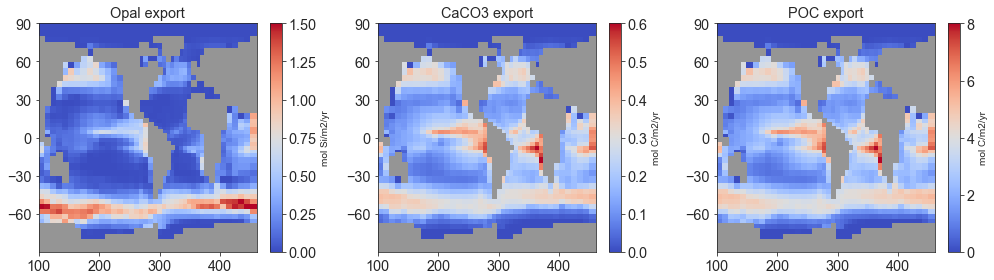

In [14]:
# plot particle export

# SETTINGS -------------------------
alpha = 1.0     # transparency
# ----------------------------------

full_obj = data_fulls[spin]
print('run = ',spin)

sns.set_style('ticks')
fig, ax = plt.subplots(1, 3, figsize=(14,4))

X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner
title = ['Opal', 'CaCO3', 'POC']
# output is in C/(m^2*s) resp. Si/(m^2*s) but will convert s to yr below
unit = ['mol Si/m2/yr', 'mol C/m2/yr', 'mol C/m2/yr']
vmin = [0.0, 0.0, 0.0] # order idem
vmax = [1.5, 0.6, 8.0] # order idem
for i,var in enumerate(['FLDOP', 'FLDCA', 'FLDPOM']):
    Z = full_obj[var].isel(time=t).values * 365.25 * 24 * 3600 # convert /s to /yr
    cpf = ax[i].pcolor(X, Y, Z, cmap='coolwarm', alpha=alpha, vmin=vmin[i], vmax=vmax[i])  
    # nice cmaps: Dark2, Set2, Accent, Spectral_r, copper 
    fig.colorbar(cpf, ax=ax[i], label=unit[i])  
    
    ax[i].pcolor(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.5, alpha=1.0) # add black land
    ax[i].set_title(title[i] + ' export')
    ax[i].set_yticks(range(-60,100,30))

plt.tight_layout()
plt.savefig(savedir / 'particles_PI.pdf')
plt.show()

Note that the patterns of CaCO3 and POC look the same (except in the Southern Ocean), because in model implementation CaCO3 is directly based on POC with a scaling factor 0.0075, except for regions with high biological silica (Southern Ocean).

# Create scaled particle fields

In [6]:
# multiply bgc values with appropriate global factor
lat = data_fulls[part_x2].lat_t
lon = data_fulls[part_x2].lon_t
time = data_fulls[part_x2].time

for var in ['FLDOP', 'FLDCA', 'FLDPOM']:
    data_fulls[part_x2][var] = data_fulls[spin][var] * 2
    data_fulls[part_x3][var] = data_fulls[spin][var] * 3
    data_fulls[part_x5][var] = data_fulls[spin][var] * 5
    data_fulls[part_div2][var] = data_fulls[spin][var] * 0.5  # divide by 2

run =  PART_DIV_2


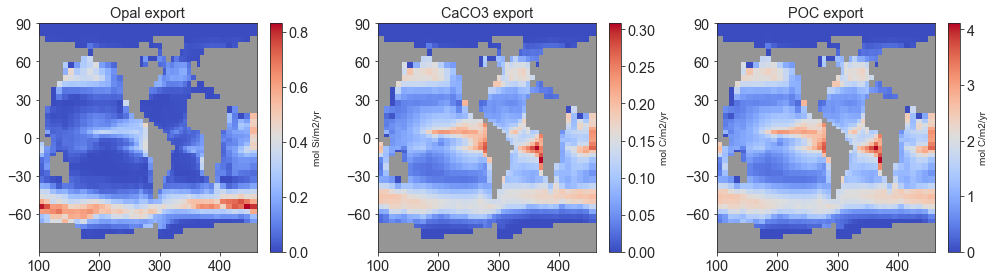

In [7]:
# plot resulting particle export to check

######## SETTINGS ######################################
run = part_div2   # choose between part_x2, part_x3, part_x5, part_div2
alpha = 1.0       # transparency
########################################################

full_obj = data_fulls[run]
print('run = ',run)
free_cbars = True

sns.set_style('ticks')
fig, ax = plt.subplots(1, 3, figsize=(14,4))

X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner
title = ['Opal', 'CaCO3', 'POC']
# output is in C/(m^2*s) resp. Si/(m^2*s) but will convert s to yr below
unit = ['mol Si/m2/yr', 'mol C/m2/yr', 'mol C/m2/yr'] # order: opal, CaCO3, POC
vmin = [0.0, 0.0, 0.0] # order idem
vmax = [1.5, 0.6, 8.0] # order idem
for i,var in enumerate(['FLDOP', 'FLDCA', 'FLDPOM']):
    Z = full_obj[var].isel(time=t).values * 365.25 * 24 * 3600 # convert /s to /yr
    if free_cbars:    
        cpf = ax[i].pcolor(X, Y, Z, cmap='coolwarm', alpha=alpha)  
    else:
        cpf = ax[i].pcolor(X, Y, Z, cmap='coolwarm', alpha=alpha, vmin=vmin[i], vmax=vmax[i])  
    # nice cmaps: Dark2, Set2, Accent, Spectral_r, copper 
    fig.colorbar(cpf, ax=ax[i], label=unit[i])  
    
    ax[i].pcolor(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.5, alpha=1.0) # add black land
    ax[i].set_title(title[i] + ' export')
    ax[i].set_yticks(range(-60,100,30))

plt.tight_layout()
plt.savefig(savedir / ('particles_x' + run[-4]+ '.pdf'))
plt.show()

In [8]:
# write result to .nc

# checks:
for field in [part_div2, part_x2, part_x3, part_x5]:
    for var in ['FLDOP', 'FLDCA', 'FLDPOM']:
        assert data_fulls[field][var].shape == (1,40,41), "shape of variable " + var + " wrong for field " + str(field)
        
data_fulls[part_div2].to_netcdf(savedir / (part_div2 + ".0001765_full_ave.nc"))
data_fulls[part_x2].to_netcdf(savedir / (part_x2 + ".0001765_full_ave.nc"))
data_fulls[part_x3].to_netcdf(savedir / (part_x3 + ".0001765_full_ave.nc"))
data_fulls[part_x5].to_netcdf(savedir / (part_x5 + ".0001765_full_ave.nc"))